## Problem Statement
Build a recommendation system for products on an e-commerce website like Amazon

Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real time. This type of filtering matches each of the user's purchased and rated items to similar items, then combines those similar items into a recommendation list for the user.

In this project we are going to build recommendation model for the electronics products of Amazon.

#### Source
Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/)  The repository has several datasets. For this case study, we are using the Electronics dataset.

#### Dataset columns
first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.


#### Steps
1.	Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics)
2.	Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )
3.	Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)
4.	Build Popularity Recommender model.
5.	Build Collaborative Filtering model.
6.	Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)
7.	Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.
8.	Summarise your insights.


In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
# Import interactive shell to run and display multiple code in a single cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
# Import Surprise package and Sigular value decomposition package

from scipy.sparse.linalg import svds
from surprise import Dataset, Reader

In [4]:
# Import dataset
col = ['userid','productid','ratings','timestamp']

df = pd.read_csv('ratings_Electronics.csv', names=col)

In [5]:
df.head()

,userid,productid,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
# checking how many rows and columns present in the dataset
df.shape

(7824482, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userid       object
productid    object
ratings      float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [8]:
# checking for nulls
df.isnull().sum()

# no null records in the dataset

userid       0
productid    0
ratings      0
timestamp    0
dtype: int64

In [9]:
print('Total unique UserID present in the dataset: {}'.format(df['userid'].nunique()))

Total unique UserID present in the dataset: 4201696


In [10]:
print('Total unique ProductID present in the dataset: {}'.format(df['productid'].nunique()))

Total unique ProductID present in the dataset: 476002


Text(0.5,1,'No. of Ratings')

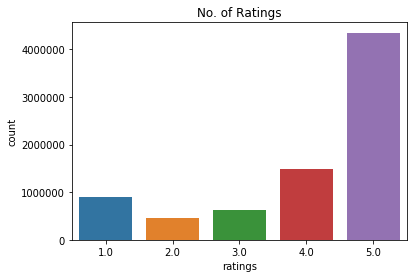

In [11]:
plt.title('No. of Ratings')
sns.countplot(df['ratings'])

# There are only 5 distinct ratings values. So no point of checking it in distribution plot

In [12]:
# dropping timestamp column, as it is not required for the analysis
df.drop(columns='timestamp', axis=1, inplace=True)

In [13]:
df.head()

,userid,productid,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [14]:
df['ratings'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: ratings, dtype: float64

In [15]:
# Showing top 10 users rated highest Products
df['userid'].value_counts().head(10)

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
Name: userid, dtype: int64

In [16]:
# Same as above in a different way; tried for practice
df.groupby('userid').size().sort_values(ascending=False)[:10]

userid
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

In [17]:
# _s for subset of original data

# taking subset of data with only users rated for more than or equal to 50 Products

user_count = df['userid'].value_counts()
df_s = df[df['userid'].isin(user_count[user_count >= 50].index)]

# df_s = df.loc[user_count.values >= 50].index

In [18]:
df_s.head()

,userid,productid,ratings
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [19]:
df_s.shape

(125871, 3)

In [20]:
print('Total unique users in the subset dataset: {}'.format(df_s['userid'].nunique()))

# whereas in original dataset, the number of user was 4201696

Total unique users in the subset dataset: 1540


In [21]:
print('Total unique products in the subset dataset: {}'.format(df_s['productid'].nunique()))

# It was 476002 in original dataset

Total unique products in the subset dataset: 48190


In [22]:
print('Number of users who have rated 50 or more items =', len(df_s))
print('Number of unique USERS in final data = ', df_s['userid'].nunique())
print('Number of unique ITEMS in final data = ', df_s['productid'].nunique())

Number of users who have rated 50 or more items = 125871
Number of unique USERS in final data =  1540
Number of unique ITEMS in final data =  48190


In [23]:
# replacing null values with 0 for the rating to be plotted in the crosstab

df_matrix = df_s.pivot(index='userid', columns='productid', values='ratings').fillna(0)

In [24]:
# Calculate density of rating matrix

# count of total given number of ratings
given_num_of_ratings = np.count_nonzero(df_matrix)


# Total possible number of ratings
possible_num_of_ratings = df_matrix.shape[0]*df_matrix.shape[1]


density = (given_num_of_ratings)/(possible_num_of_ratings)*100

In [25]:
print ('density: {:4.2f}%'.format(density))

# result:
    # density looks to be very less, means data is highly sparsh
    # Therefore, we have to use SVD method to proceed with further recommendation

density: 0.17%


In [26]:
df_matrix.head()

productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userid,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# split data set into train & test set.

train_data, test_data = train_test_split(df_s, test_size = 0.3, random_state=9)
train_data.head()

,userid,productid,ratings
2283146,A2WLNSZ9U0T1S3,B001SEQN3U,4.0
6943885,A2XIOXRRYX0KZY,B00AR95FOU,4.0
6083141,A3AZI828WJN1CD,B0085YTCYS,3.0
6105233,AMKNPIDFLRFMP,B0088CJT4U,5.0
974734,A5A4374R8I7NB,B000GLIIFW,4.0


In [28]:
train_data.shape

(88109, 3)

In [29]:
test_data.shape

(37762, 3)

## Popularity Recommender model (Non-personalised)
Product pupularity based system targetted at new customers

In [30]:
# Count of userid for each unique productid as recommendation score 

train_data_grp = train_data.groupby('productid').agg({'userid':'count'}).reset_index()
train_data_grp.rename(columns = {'userid': 'score'},inplace=True)

In [31]:
train_data_grp.head()

,productid,score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,3


In [32]:
# Sort the products on recommendation score 

train_data_sort = train_data_grp.sort_values(by=['score', 'productid'], ascending=False)

In [33]:
# Generate a recommendation rank based upon score

train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first').head(20)

In [34]:
# Get the top 5 recommendations

popularity_recommendations = train_data_sort.head(5)
popularity_recommendations

,productid,score,rank
30741,B0088CJT4U,130,1.0
19526,B003ES5ZUU,119,2.0
8648,B000N99BBC,119,3.0
30160,B007WTAJTO,115,4.0
30449,B00829TIEK,101,5.0


In [35]:
# Use popularity based recommender model to make predictions

def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    # Add userid column for which the recommendations are being generated 
    user_recommendations['userID'] = user_id 
      
    # Bring userid column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [36]:
# check recommend based on userid.
# Examples:

recommend('A2BYV7S1QP2YIG')
recommend('AB094YABX21WQ')

# Since this is a popularity-based recommender model, recommendations remain the same for all users
# We predict the products based on the popularity. It is not personalized to particular user

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,userID,productid,score,rank
30741,A2BYV7S1QP2YIG,B0088CJT4U,130,1.0
19526,A2BYV7S1QP2YIG,B003ES5ZUU,119,2.0
8648,A2BYV7S1QP2YIG,B000N99BBC,119,3.0
30160,A2BYV7S1QP2YIG,B007WTAJTO,115,4.0
30449,A2BYV7S1QP2YIG,B00829TIEK,101,5.0


,userID,productid,score,rank
30741,AB094YABX21WQ,B0088CJT4U,130,1.0
19526,AB094YABX21WQ,B003ES5ZUU,119,2.0
8648,AB094YABX21WQ,B000N99BBC,119,3.0
30160,AB094YABX21WQ,B007WTAJTO,115,4.0
30449,AB094YABX21WQ,B00829TIEK,101,5.0


The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be 
not suitable to the user. The Popularity based model has recommended 
the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the 
user past purchase history

## Collaborative Filtering model using SVD method
Model-based collaborative filtering system based on customer's purchase history and ratings provided by other users who bought items similar items

In [37]:
# resetting index for the collaborative filter
df_CF = df_s.reset_index()

In [38]:
df_CF.head()

,index,userid,productid,ratings
0,94,A3BY5KCNQZXV5U,0594451647,5.0
1,118,AT09WGFUM934H,0594481813,3.0
2,177,A32HSNCNPRUMTR,0970407998,1.0
3,178,A17HMM1M7T9PJ1,0970407998,4.0
4,492,A3CLWR1UUZT6TG,0972683275,5.0


In [39]:
# Matrix with row per 'user' and column per 'item' 

pivot_df = df_CF.pivot(index = 'userid', columns ='productid', values = 'ratings').fillna(0)
pivot_df.shape
pivot_df.head()

(1540, 48190)

productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userid,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# creating a new column 'user_index' which is a sequential number from 0 to total number of users

pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.set_index(['user_index'], inplace=True)
pivot_df.head()

productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Implementing SVD
SVD (Singular Value Decomposition) is best to apply on a large sparse matrix

In [41]:
# Extracting U, sigma and Vt from the svd function
U, sigma, Vt = svds(pivot_df, k = 10)

# diagonal array for sigma
sigma = np.diag(sigma)

In [42]:
# calculating M (Matrix); which is a dot product of U, sigma and Vt

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings

preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [43]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1, sort=False)
    temp.index.name = 'Recommended Products'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [44]:
#Enter 'userID' and 'num_recommendations' for the user #

userID = 1500
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended products for user(user_id = 1500):

                      user_ratings  user_predictions
Recommended Products                                
B003ES5ZUU                     0.0          1.078326
B007WTAJTO                     0.0          0.933721
B002V88HFE                     0.0          0.635227
B00829TIEK                     0.0          0.590629
B002SZEOLG                     0.0          0.519811


#### Model Evaluation

In [45]:
# Once the model is trained on the training data, \
# it can be used to compute the error (RMSE) on predictions made on the test data

# Actual ratings given by the users
df_matrix.head()

productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userid,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Average Actual rating for each product
df_matrix.mean().head()

productid
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [47]:
# Predicted ratings 
preds_df.head()

productid,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [48]:
# Average Predicted rating for each item
preds_df.mean().head()

productid
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [49]:
rmse_df = pd.concat([df_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productid,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [50]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will 
recommend 5 new products.

In [51]:
# Example:
userID = 999
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended products for user(user_id = 999):

                      user_ratings  user_predictions
Recommended Products                                
B0088CJT4U                     0.0          1.069630
B000N99BBC                     0.0          0.876860
B00829TIEK                     0.0          0.748533
B008DWCRQW                     0.0          0.704374
B004CLYEFK                     0.0          0.667480


Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of 
the user and it is not dependent on any additional information.

## Using Surprise package

In [52]:
# To avoid out of memory system error, using a smaller dataset with Surprise package
df_sm = df[df['userid'].isin(user_count[user_count >= 250].index)]

In [53]:
print('Number of users who have rated 50 or more items =', len(df_sm))
print('Number of unique USERS in final data = ', df_sm['userid'].nunique())
print('Number of unique ITEMS in final data = ', df_sm['productid'].nunique())

Number of users who have rated 50 or more items = 7484
Number of unique USERS in final data =  23
Number of unique ITEMS in final data =  5841


In [54]:
# Transform data to surprise format.
# Here using the subset data where we have captured users only gave ratings for 50 or more products.
from surprise import Dataset, Reader

reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df_sm[['userid', 'productid', 'ratings']], reader)

In [55]:
data

In [56]:
# Split data to train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.30,random_state=9)

In [57]:
len(testset)

2246

In [59]:
# don't know why it is not working!!!
len(trainset)

TypeError: object of type 'Trainset' has no len()

In [60]:
# user item rating data can be obtained as follows
user_records = trainset.ur
type(user_records)

collections.defaultdict

In [61]:
# surprise package converts raw id into inner id, which are nothing but numeric indexes
for keys in user_records.keys():
    print(keys)
    if keys == 5:
        break

0
1
2
3
4
5


In [96]:
user_records[5]

[(5, 5.0),
 (10, 5.0),
 (14, 4.0),
 (48, 5.0),
 (90, 4.0),
 (106, 5.0),
 (128, 5.0),
 (137, 5.0),
 (152, 5.0),
 (157, 4.0),
 (170, 5.0),
 (196, 5.0),
 (243, 3.0),
 (264, 2.0),
 (266, 5.0),
 (280, 5.0),
 (122, 3.0),
 (321, 5.0),
 (375, 3.0),
 (419, 4.0),
 (436, 4.0),
 (535, 4.0),
 (558, 5.0),
 (595, 5.0),
 (467, 5.0),
 (604, 5.0),
 (614, 5.0),
 (620, 3.0),
 (667, 5.0),
 (731, 5.0),
 (734, 5.0),
 (845, 5.0),
 (847, 5.0),
 (855, 5.0),
 (938, 5.0),
 (950, 5.0),
 (953, 5.0),
 (1028, 5.0),
 (1065, 5.0),
 (1092, 5.0),
 (1105, 5.0),
 (1151, 5.0),
 (1154, 5.0),
 (1198, 5.0),
 (1210, 5.0),
 (1217, 5.0),
 (1331, 5.0),
 (1354, 3.0),
 (1479, 5.0),
 (1494, 4.0),
 (1498, 4.0),
 (1505, 5.0),
 (1524, 5.0),
 (1558, 5.0),
 (1576, 5.0),
 (1581, 3.0),
 (1616, 5.0),
 (1629, 4.0),
 (1668, 5.0),
 (1689, 4.0),
 (1695, 5.0),
 (1352, 5.0),
 (1733, 4.0),
 (1735, 5.0),
 (462, 5.0),
 (1817, 3.0),
 (637, 5.0),
 (1844, 5.0),
 (1890, 5.0),
 (1906, 4.0),
 (1931, 5.0),
 (1980, 4.0),
 (1993, 5.0),
 (1109, 4.0),
 (1364, 4

In [63]:
# raw ids can be obatined as follows

print(trainset.to_raw_uid(5))
print(trainset.to_raw_iid(999))

A3EXWV8FNSSFL6
B005NGLTZQ


In [64]:
# Training the model
from surprise import KNNWithMeans
from surprise import accuracy

In [65]:
# Item based model
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson', 'user_based': False})

In [66]:
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [67]:
testset[0:10]

[('A3LGT6UZL99IW1', 'B0097CXWUW', 4.0),
 ('A23GFTVIETX7DS', 'B0035JCI6M', 1.0),
 ('A17BUUBOU0598B', 'B009NE5YC8', 2.0),
 ('A38RMU1Y5TDP9', 'B001O8O9PO', 5.0),
 ('A1ODOGXEYECQQ8', 'B0085YTDBA', 3.0),
 ('A23GFTVIETX7DS', 'B009FPUBBE', 4.0),
 ('A3AYSYSLHU26U9', 'B008YDTRLS', 3.0),
 ('A3LGT6UZL99IW1', 'B002SH43MO', 5.0),
 ('A38RMU1Y5TDP9', 'B002LITT5Q', 4.0),
 ('A36K2N527TXXJN', 'B00CJKW4WQ', 4.0)]

In [68]:
# Evalute on test set
test_pred = algo.test(testset)

# compute RMSE
accuracy.rmse(test_pred)

RMSE: 0.9584


0.9584065893454665

In [69]:
# View a particular prediction
test_pred[9]

Prediction(uid='A36K2N527TXXJN', iid='B00CJKW4WQ', r_ui=4.0, est=4.318633066055747, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'})

In [70]:
# To access a particular value, say estimate simply mention test_pred[9].est
test_pred[9].est

4.318633066055747

In [71]:
# convert results to dataframe
test_pred_df = pd.DataFrame(test_pred)
test_pred_df["was_impossible"] = [x["was_impossible"] for x in test_pred_df["details"]]

In [72]:
test_pred_df.loc[test_pred_df.was_impossible].head(5)

,uid,iid,r_ui,est,details,was_impossible
1,A23GFTVIETX7DS,B0035JCI6M,1.0,4.318633,"{'was_impossible': True, 'reason': 'User and/o...",True
2,A17BUUBOU0598B,B009NE5YC8,2.0,4.318633,"{'was_impossible': True, 'reason': 'User and/o...",True
3,A38RMU1Y5TDP9,B001O8O9PO,5.0,4.318633,"{'was_impossible': True, 'reason': 'User and/o...",True
4,A1ODOGXEYECQQ8,B0085YTDBA,3.0,4.318633,"{'was_impossible': True, 'reason': 'User and/o...",True
5,A23GFTVIETX7DS,B009FPUBBE,4.0,4.318633,"{'was_impossible': True, 'reason': 'User and/o...",True


### Using SVD model with Surprise package

In [73]:
from surprise import SVD

In [74]:
svd_model = SVD(n_factors=50,biased=False)
svd_model.fit(trainset)

In [75]:
test_pred = svd_model.test(testset)

In [76]:
# compute RMSE
accuracy.rmse(test_pred)

RMSE: 1.8619


1.8618846103389715

#### Recreating the SVD predictions using Matrix multiplcation of User and Item factors

In [77]:
user_factors = svd_model.pu
user_factors.shape
item_factors = svd_model.qi
item_factors.shape

(23, 50)

(4331, 50)

In [78]:
pred = np.dot(user_factors,np.transpose(item_factors))

In [79]:
pred[21,0:5]

array([ 0.09232077, -0.37900983, -0.21195178,  1.29013846, -0.27338543])

In [80]:
svd_model.predict(uid = trainset.to_raw_uid(21), iid = trainset.to_raw_iid(0))

Prediction(uid='A3PD8JD9L4WEII', iid='B001DJ64D4', r_ui=None, est=1, details={'was_impossible': False})

<b> Parameter tuning of SVD Recommendation system </b>

In [81]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors' : [5,10,15], "reg_all":[0.01,0.02]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3,refit = True)

In [82]:
gs.fit(data)

In [83]:
# get all parameter combinations
gs.param_combinations

[{'n_factors': 5, 'reg_all': 0.01},
 {'n_factors': 5, 'reg_all': 0.02},
 {'n_factors': 10, 'reg_all': 0.01},
 {'n_factors': 10, 'reg_all': 0.02},
 {'n_factors': 15, 'reg_all': 0.01},
 {'n_factors': 15, 'reg_all': 0.02}]

In [84]:
# get best parameters
gs.best_params

{'rmse': {'n_factors': 10, 'reg_all': 0.02}}

In [86]:
# Use the "best model" for prediction
# gs.test(testset)

In [89]:
svd_model_final = SVD(n_factors=10, biased=False)
svd_model_final.fit(trainset)

In [91]:
test_pred_final = svd_model_final.test(testset)

In [92]:
# compute RMSE
accuracy.rmse(test_pred_final)

# Result: RMSE value improved then the SVD model we used earlier with n_factors=50

RMSE: 1.7989


1.7988858974763393

## Conclusion

- Explored data after importing.
- Took subset of data with UserID who has given 50 or more ratings
- Built a pivot matrix and checked the density, which came around 0.17%
- Split data into train and test set
- Created a new DF by aggregating the UserID by ProductID and rank them
- Created a function 'recommend', which takes input as UserID and returns top 5 recommended products based on popularity recommender
- For IBCF, used SVD model as data is highly sparse with density around 0.17%
- Created a function 'recommend_items' which takes UserID and number of recommendations as input
- It also takes matrix data and predicted data as Input, which returns top 5 recommended products for the User and predicted ratings
- Evaluated the RMSE of SVD model, which comes around 0.0033. It tells that model is doing fairly well with less error. But data is sparse and for many products ratings are not available
- The above conclusion tells, Collaborative filtering model is a data hungry model. The evaluation would be more proper once ratings are there for most of products.

-----
     
- Then used Surprise package to construct an SVD model.
- Used smaller dataset due to system memory error.
- Transformed data to surprise format using reader and dataset methods. Here Surprise package converts all raw ids into inner ids.
- Split the dataset into train and test set.
- Used KNNWithMeans and SVD models from surprise package and checked the accuracy. KNNWithMeans looks to perform better for this dataset.
- Tuned the parameters for SVD model using grid search and using best hyper parameters the SVD model performed slightly better.
- Point to note, I have tried Surprise package for practice purpose. Few concepts like details={'was_impossible': False} is not clear to me. I have been exploring it further.

-----

- Overall it looks like IBCF with SVD model performed well with this dataset.

